# Fine-Tuning Llama2 using LoRA & QLoRA on custom dataset

### Let’s dive into the details of fine-tuning Llama 2 using LoRA and QLoRA:

 * Llama 2:
Llama 2 is a large language model (LLM) developed by Meta (formerly Facebook AI).
It’s designed for natural language understanding and generation tasks.
Fine-tuning allows adapting pre-trained LLMs like Llama 2 to specific downstream tasks.

 * LoRA (Low-rank Adaptation):
LoRA is a parameter-efficient fine-tuning technique.
Instead of updating all LLM parameters during fine-tuning, LoRA adds small, task-specific modules (adapters) to the pre-trained LLM.
These adapters are trained while keeping the rest of the LLM parameters fixed.

Benefits:
Faster training.
Reduced memory requirements.
Reusability for multiple tasks.

* QLoRA (Quantization + LoRA):
QLoRA combines LoRA with quantization.
Quantization reduces the memory footprint by representing model weights with fewer bits (e.g., 4-bit or 8-bit integers).
The fine-tuned model is both efficient and effective.
QLoRA is particularly useful when resources are limited.

* Fine-Tuning Process:
Assume you have a pre-trained Llama 2 model.
To fine-tune it using QLoRA:
Identify the specific task (e.g., chatbot, text generation) you want to adapt the model for.
Add a small adapter module (QLoRA) to the Llama 2 architecture.
Train the adapter using task-specific data while keeping the rest of Llama 2 fixed.
The adapter learns to adjust the Llama 2 output for the specific task.
The fine-tuned model combines the pre-trained Llama 2 and the trained adapter.

* Practical Implementation:
You can find practical examples and notebooks for fine-tuning Llama 2 with QLoRA on platforms like Google Colab.
These notebooks guide you through the process step by step.
In summary, LoRA and QLoRA allow you to customize powerful LLMs like Llama 2 for specific tasks efficiently and effectively. 🚀🐍

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Imports
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

## **In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

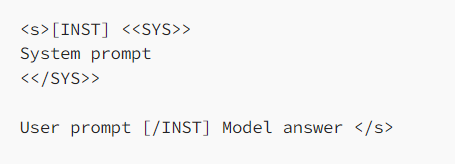

## We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

## How to fine tune Llama 2
- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)
- We also need to consider the overhead due to optimizer states, gradients, and forward activations
- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.
- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

## what PEFT technique(LoRA & QLoRA) does ?
#### PEFT basically do, it is going to freeze most of the weights, and only after applying quantisation it is going to preform fine-tuning of some weights i.e going to change weights

In [7]:
# loading Llama2 model ( 7b parameter)
model_name = "NousResearch/Llama-2-7b-chat-hf"

# load the instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# FineTuned Model name
new_model = "Llama-2-7b-chat-finetuned"

# QLoRA parameters
lora_r = 64  # LoRA attention dimension
lora_alpha = 16 # Alpha parameter for LoRA Scaling
lora_dropout = 0.1 # dropout probability for LoRA layers

# bitsandbytes parameters

# Activate 4-bit precision base model loading
use_4bit = True
bnb_4bit = True # activate 4-bit precision base model loading
bnb_4bit_compute_dtype = "float16" # compute dtype for 4-bit base models
bnb_4bit_quant_type = "nf4"  # Quantization type (fp4 / nf4)
use_nested_quant = False

In [4]:
# Training Arguments Parameters

output_dir = ".results"

num_train_epochs = 1

# enable fp16/bf16 training (set bf16 to True with an A100)
# as i use free tier of GOOGLE COLAB , GPU is T4
fp16 = False
bf16 = False

per_device_train_batch_size = 4 # batch size per GPU for training
per_device_eval_batch_size =4 # batch size per GPU for eval
gradient_accumulation_steps =1 # number of update steps to accumulate the gradient for

gradient_checkpointing = True # enable gradient checkpoint

max_grad_norm = 0.3 # max. gradient normal (gradient clipping)

learning_rate = 2e-4 # Initial learning rate (AdamW optimizer)

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25


In [5]:
# SFT parameters

max_seq_length = None # max. sequence length to use

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU
device_map = {"": 0}

##**Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [8]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.408400
50,1.663400
75,1.215600
100,1.445400
125,1.178100
150,1.366100
175,1.173900
200,1.468400
225,1.158300
250,1.542700


TrainOutput(global_step=250, training_loss=1.3620326156616211, metrics={'train_runtime': 1528.017, 'train_samples_per_second': 0.654, 'train_steps_per_second': 0.164, 'total_flos': 8755214190673920.0, 'train_loss': 1.3620326156616211, 'epoch': 1.0})

In [9]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()